# Test scripts on command line
Use this notebook as a test space

In [ ]:
!pip install -U -r /projects/Developer/icesat2_boreal/dps/requirements_main.txt
!pip install pystac_client
from platform import python_version
python_version()
import sys
sys.path.append('/projects/icesat2_boreal/lib')
sys.path.append('/projects/Developer/icesat2_boreal_new/icesat2_boreal/lib')
import ExtractUtils
from pyproj import CRS, Transformer
import geopandas as gpd
import maplib_folium

In [ ]:
!python /projects/Developer/icesat2_boreal/lib/build_tindex_master.py -t ATL08 -y 2022 -m_list 01 02 03
#!python /projects/icesat2_boreal/lib/build_tindex_master.py -t ATL08_filt -y 2022 -m run_LC_height_thresholds -o /projects/my-private-bucket/

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string

Building a list of tiles:
MAAP version:		master
Type:		ATL08
Year:		2022
Month:		['01', '02', '03']
Days:		1-31

Output dir:  /projects/my-public-bucket/DPS_tile_lists


### Read in some tiles layers

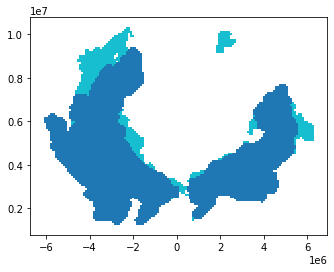

In [2]:

dem_tiles_index_path = '/projects/shared-buckets/nathanmthomas/dem30m_tiles.geojson'
dem_tiles_index = gpd.read_file(dem_tiles_index_path)
dem_tiles_index['tile_num'] = dem_tiles_index.index

boreal_tile_index_path = '/projects/my-public-bucket/old_boreal_tiles/boreal_tiles_v003_old.gpkg'
boreal_tile_index = gpd.read_file(boreal_tile_index_path)
boreal_tile_index.plot(column='tile_version')

#boreal_tile_index[boreal_tile_index.tile_version=='version 2']

#### Set up vars to pass to each script

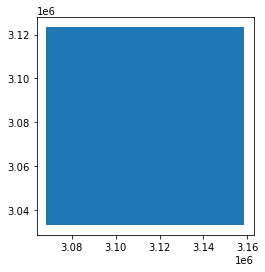

In [7]:
#TILE_NUM = 12967
#INDEX_FN = '/projects/shared-buckets/lduncanson/dem30m_tiles_v2.geojson'#
#INDEX_LYR = 'dem30m_tiles_v2'

#TILE_NUM = [38380, 37748, 2270, 2422, 2500, 2583, 2739, 2900, 2988, 2653, 2810, 2886, 2805][0]
TILE_NUM = 3476
INDEX_FN = '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg'
INDEX_LYR = 'boreal_tiles_v003'
z = gpd.read_file(INDEX_FN)
z[z.tile_num==TILE_NUM].plot()

#### Test a run of the topo stacks: 3.1.5_dps.py

In [ ]:
args = f"--in_tile_fn {INDEX_FN} \
--in_tile_num {TILE_NUM} \
--tile_buffer_m 120 \
--in_tile_layer {INDEX_LYR} \
-o /projects/test_data/ \
--topo_tile_fn /projects/shared-buckets/nathanmthomas/dem30m_tiles.geojson"
print(args)
!python 3.1.5_dps.py $args

#### Test a run of the MS comp stacks: 3.1.2_dps.py

In [8]:
MS_DATA_TYPE = 'LS8' # 'HLS'
if MS_DATA_TYPE == 'LS8':
    SAT_API = 'https://landsatlook.usgs.gov/sat-api'
else:
    SAT_API = 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD'
MAX_CLOUDS = 25
SEASON_START = '7-01'
SEASON_STOP = '09-01'
YEAR_START = '2019'
YEAR_STOP = '2021'
RUN_NAME = f'mc{MAX_CLOUDS}_{SEASON_START}_{SEASON_STOP}_{YEAR_START}_{YEAR_STOP}'
RUN_NAME

'mc25_7-01_09-01_2019_2021'

In [9]:
args = f"-i {INDEX_FN} \
--in_tile_num {TILE_NUM} \
-lyr {INDEX_LYR} \
-o /projects/test_data \
-a {SAT_API} \
--tile_buffer_m 0 \
-sy {YEAR_START} -ey {YEAR_STOP} -smd {SEASON_START} -emd {SEASON_STOP} -mc {MAX_CLOUDS} -t {MS_DATA_TYPE}"
print(args)
!python 3.1.2_dps.py $args

-i /projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg --in_tile_num 3476 -lyr boreal_tiles_v003 -o /projects/test_data -a https://landsatlook.usgs.gov/sat-api --tile_buffer_m 0 -sy 2019 -ey 2021 -smd 7-01 -emd 09-01 -mc 25 -t LS8
/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string

Tiles path:		 /projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg
Tile number:		 3476
Output res (m):		 30
in_bbox:		 [3068521.9999999953, 3033304.0000000093, 3158521.9999999953, 3123304.0000000093]
bbox 4326:		 [-125.09810592409934, 54.8513319681673, -123.06962644374654, 55.98147942810227]
get ls8 data

Printing tile parts:
	{'geom_orig':       tile_num  ...                                           geometry
3475      3476  ...  POLYGON ((3068522

#### Test a run of tile_atl08.py

In [32]:
%%time
args = f"\
-LC_filter True \
--extract_covars \
--do_30m \
--do_dps \
-years_list 2019 2020 2021 \
-o /projects/my-public-bucket/atl08_filt_covar_tiles \
-in_tile_num {TILE_NUM} \
-in_tile_fn {INDEX_FN} \
-in_tile_layer {INDEX_LYR} \
-in_tile_id_col tile_num \
-csv_list_fn /projects/shared-buckets/lduncanson/DPS_tile_lists/ATL08_tindex_master.csv \
-topo_stack_list_fn /projects/shared-buckets/nathanmthomas/DPS_tile_lists/Topo_tindex_master.csv \
-landsat_stack_list_fn /projects/shared-buckets/nathanmthomas/DPS_tile_lists/HLS_tindex_master.csv \
-landsat_cols_list Blue Green Red NIR SWIR SWIR2 NDVI SAVI MSAVI NDMI EVI NBR NBR2 TCB TCG TCW ValidMask Xgeo Ygeo JulianDate yearDate \
-user_stacks nathanmthomas \
-user_atl08 lduncanson \
-thresh_sol_el 5 \
-v_ATL08 5 -minmonth 4 -maxmonth 10"
print(args)
!python tile_atl08.py $args

-LC_filter True --extract_covars --do_30m --do_dps -years_list 2019 2020 2021 -o /projects/my-public-bucket/atl08_filt_covar_tiles -in_tile_num 2717 -in_tile_fn /projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg -in_tile_layer boreal_tiles_v003 -in_tile_id_col tile_num -csv_list_fn /projects/shared-buckets/lduncanson/DPS_tile_lists/ATL08_tindex_master.csv -topo_stack_list_fn /projects/shared-buckets/nathanmthomas/DPS_tile_lists/Topo_tindex_master.csv -landsat_stack_list_fn /projects/shared-buckets/nathanmthomas/DPS_tile_lists/HLS_tindex_master.csv -landsat_cols_list Blue Green Red NIR SWIR SWIR2 NDVI SAVI MSAVI NDMI EVI NBR NBR2 TCB TCG TCW ValidMask Xgeo Ygeo JulianDate yearDate -user_stacks nathanmthomas -user_atl08 lduncanson -thresh_sol_el 5 -v_ATL08 5 -minmonth 4 -maxmonth 10
/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CA